## Kaggle Titanic

### feat6
On top of dropping name and passengerId this branch will drop cabin as well (seems trivial).

In [24]:
%%bash
git branch

  CV_check
  cost1/feat1/wip
  cost1/feat2/wip
  cost1/wip
  feat1/score1/wip
  feat1/wip
  feat2/score1/wip
  feat2/wip
  feat3/wip
  feat4/wip
  feat5/wip
* feat6/wip
  master


In [93]:
%%bash
git add Titanic.ipynb
git add Test_data.ipynb
git commit -m 'Need to train feat6 model again, previous version is wrong'
git push --set-upstream origin feat5/wip

[feat6/wip c5b1212] Finished testing
 1 file changed, 1372 insertions(+), 1381 deletions(-)
Branch feat5/wip set up to track remote branch feat5/wip from origin.


Everything up-to-date


In [73]:
filename ='feat6.sav'

As usual, import all neccasary stuff into the notebook

In [7]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First, I will start by loading the data in panda dataframe and do some EDA.

In [8]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
print(train.shape)

(891, 12)


Take a peek look at raw data table.

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It appears that the test data has no label(answer class) and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only. Next, split dataframe into X and Y dataframe where X store the data while Y store the label.
Also dropping name right of the bat.

In [10]:
X = train.copy()
#X = X.drop('Survived',axis=1)
X = X.drop('PassengerId',axis=1)  # Shouldn't relate to survival chance
X = X.drop('Name',axis=1)  # Shouldn't relate to survival chance
X = X.drop('Cabin',axis=1)

test = test.drop('PassengerId',axis=1)
test = test.drop('Name',axis=1)
test = test.drop('Cabin',axis=1)

Y = pd.DataFrame(train['Survived'])

### Label Class Distribution
Lets take a look at class (Survived) distribution, the distribution is slightly skew where more passengers didn't survive.

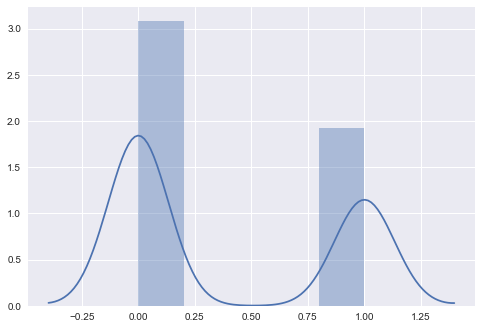

In [11]:
#Y_dist=pd.DataFrame(Y.label.value_counts())
#Y_dist = Y_dist.reset_index()
#Y_dist.columns = ['label','count']
#Y_dist = Y_dist.set_index('label').sort_index().reset_index()
sns.distplot(Y);

Sanitizing data, finding all NaN data in X

In [12]:
X.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Embarked     True
dtype: bool

### Numerical Distribution Plots
Take a look at each numerical atrributes distribution.

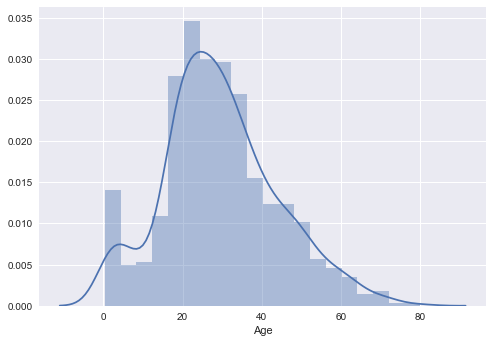

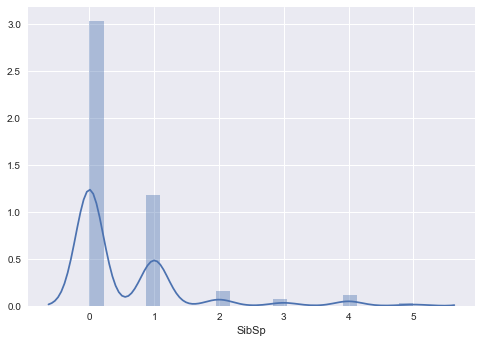

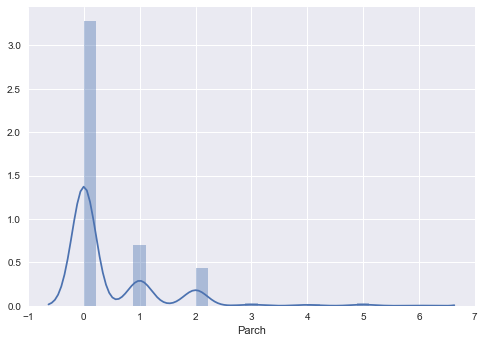

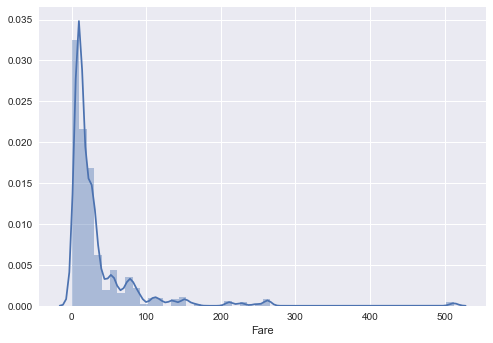

In [14]:
#Divide Numerical and Categorical attributes
#Pclass is actually categorical
num_attri = ['Age','SibSp','Parch','Fare']
cat_attri = [column for column in X if (column not in num_attri and column != 'Survived')]
#print(num_attri)
#print(cat_attri)
#Plot numerical variables
for i,column in enumerate(num_attri):
    #print(column)
    plt.figure(i)
    sns.distplot(X[column])

### Categorical Bar Plots
Now, for categorical attributes, make a bar plot.

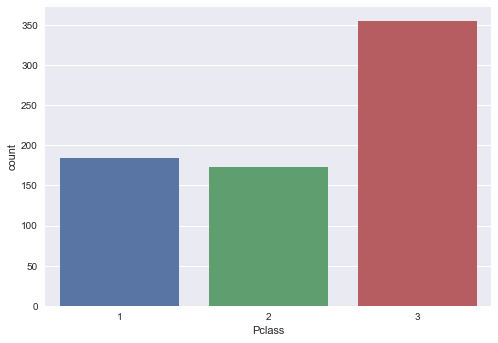

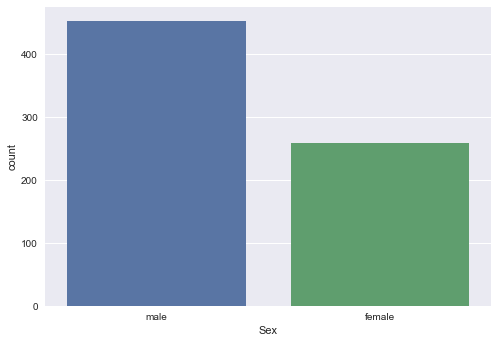

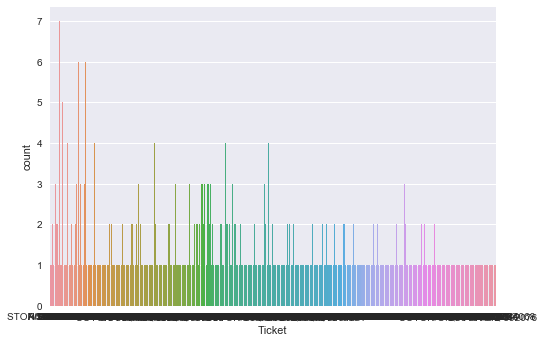

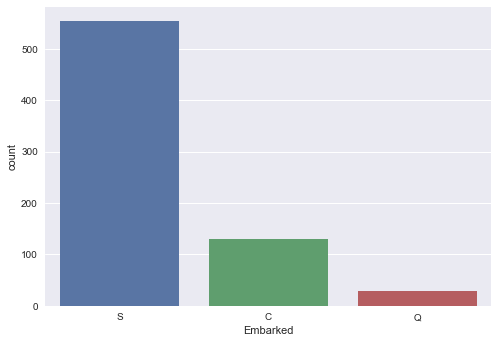

In [15]:
for i,column in enumerate(cat_attri):
    #Lets just keep every categorical attributes for plotting
    plt.figure(i)
    sns.countplot(X[column])

Observation: Majority of Pclass is class 1. Name, as one might expected, is equally distributed (one count for each name). Sex count is equal. Some spikes in Ticket and Cabin. Very small Q (Queenstown) counts for Embarked.

### Pairplot
Make a pairplot for all numerical variables

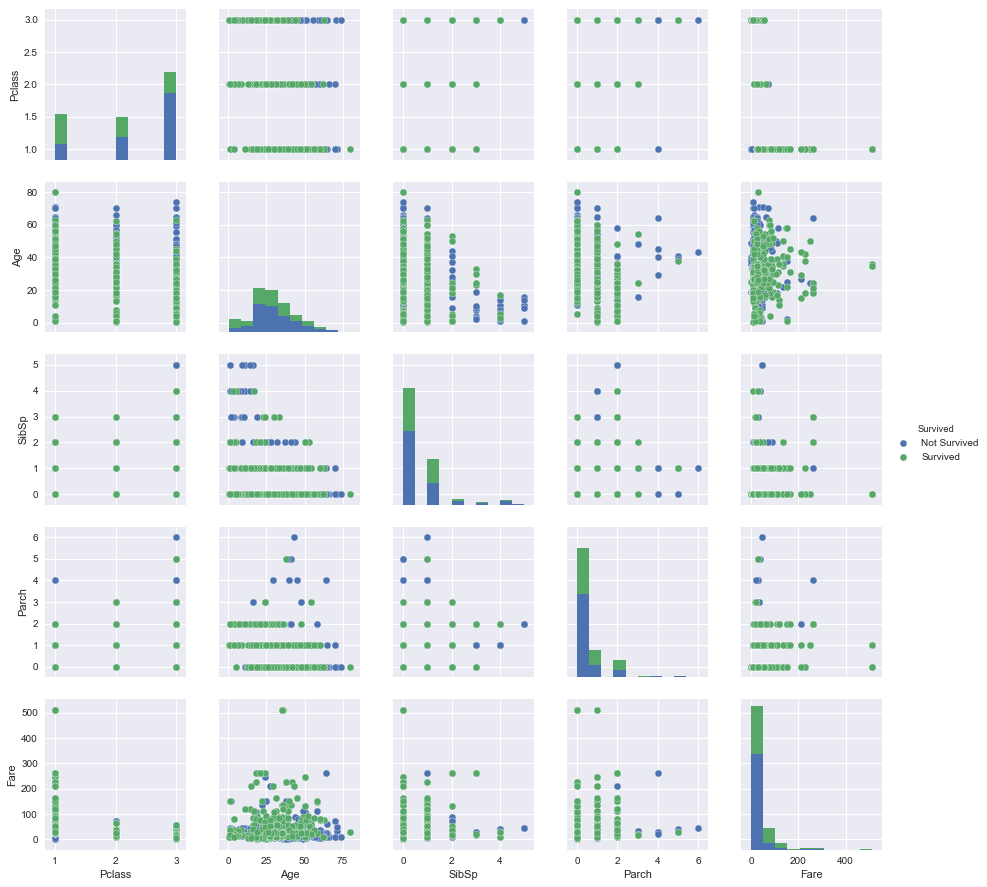

In [16]:
# Make new dataframe for pairplot purpose
X_pairplot = X.copy()
X_pairplot.loc[X_pairplot['Survived']==1,'Survived'] = 'Survived'
X_pairplot.loc[X_pairplot['Survived']==0,'Survived'] = 'Not Survived'

#X_pairplot[Survived=0] = 'Not Survived'

#Add Survived category to numerical attributes for plotting purpose
if 'Survived' not in num_attri:
    num_attri = num_attri + ['Survived']
    
g = sns.pairplot(X_pairplot,hue='Survived')

### Dummy Variables
For starter, create dummy variables for categorical features.

In [17]:
for column in (cat_attri):
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(X[column],prefix=column)
    X.drop(column,axis=1,inplace=True)
    X = X.join(tempDF)

for column in (cat_attri): #Create dummy for test
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(test[column],prefix=column)
    test.drop(column,axis=1,inplace=True)
    test = test.join(tempDF)

#Concat X(train data) with X from test data to avoid mismatch feature
train_objs_num = len(X)
dataset = pd.concat(objs=[X, test], axis=0)
#dataset = pd.get_dummies(dataset)
X = dataset[:train_objs_num].copy()
test = dataset[train_objs_num:].copy()

In [18]:
X.head()

,Age,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Ticket_SW/PP 751,Ticket_W./C. 14258,Ticket_W./C. 14260,Ticket_W./C. 14263,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
0,22.0,0,0,1,7.2500,0,0,0,1,0,...,0.0,0.0,NaN,0.0,NaN,NaN,0,0,0.0,0.0
1,38.0,1,0,0,71.2833,0,1,0,0,1,...,0.0,0.0,NaN,0.0,NaN,NaN,0,0,0.0,0.0
2,26.0,0,0,1,7.9250,0,0,0,1,1,...,0.0,0.0,NaN,0.0,NaN,NaN,0,0,0.0,0.0
3,35.0,0,0,1,53.1000,0,1,0,0,1,...,0.0,0.0,NaN,0.0,NaN,NaN,0,0,0.0,0.0
4,35.0,0,0,1,8.0500,0,0,0,1,0,...,0.0,0.0,NaN,0.0,NaN,NaN,0,0,0.0,0.0


### Feature Evaluation
For starter using random forest to evaluate feature importance.
Code shamelessly brought from:http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [86]:
#Format dataframe for scikit training
y = X['Survived']
X.drop('Survived',axis=1,inplace=True)

Start with numerical feature ranking first

In [87]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                          n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(18,14))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### Model Training
For the sake of early versions use all features for learning. Use 5 fold CV grid search (with 1 fold labelled test set and will not be the part of parameter tuning)

First split into 4:1 train/CV and test dataset and use feature that passed only the mentioned threshold of importance score

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

clf = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        )
# specify parameters via map
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': np.arange(1,11,1),
              'subsample': np.arange(0.1,0.9,0.1).tolist(),
              'colsample_bytree': np.arange(0.5,0.9,0.1).tolist()}

clf = GridSearchCV(clf, parameters, n_jobs=1, 
                   cv=4, 
                   scoring='accuracy',
                   verbose=2, refit=False)
clf.fit(X_train,y_train)
best_param_4CV = clf.best_params_

Fitting 4 folds for each of 320 candidates, totalling 1280 fits
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.2s
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.1s
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.1s
[CV] objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.1, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.1s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.1s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.5, max_depth=1 -   0.1s
[CV] objective=binary:logistic, subsa

[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:  9.5min finished


Performance on the 4thCV fold

In [90]:
print('Best AUC score:'+str(clf.best_score_))
print('Best Param:' +str(clf.best_params_))

Best AUC score:0.82776801406
Best Param:{'objective': 'binary:logistic', 'subsample': 0.5, 'learning_rate': 0.05, 'colsample_bytree': 0.7999999999999999, 'max_depth': 7}


Now check performance on accuracy basis.

In [91]:
clf2 = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        colsample_bytree = best_param_4CV['colsample_bytree'],
        learning_rate = best_param_4CV['learning_rate'],
        max_depth =  best_param_4CV['max_depth'],
        objective = best_param_4CV['objective'],
        subsample = best_param_4CV['subsample']
        )
clf2.fit(X_train,y_train)

import pickle
# save the model to disk
pickle.dump(clf2, open(filename, 'wb'))

from sklearn.metrics import accuracy_score
print('Accuracy:'+str(accuracy_score(y_train,clf2.predict(X_train))))

Accuracy:0.919156414763


Now check performance on the test set.

In [92]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
print('Test set AUC score:'+str(roc_auc_score(y_test,clf2.predict(X_test))))
print('Test set Accuracy:'+str(accuracy_score(y_test,clf2.predict(X_test))))

Test set AUC score:0.808829365079
Test set Accuracy:0.818181818182
